In [1]:
#pip install --user git+https://github.com/brazil-data-cube/EOCubes@master --upgrade --no-cache-dir

In [2]:
### Import eocubes ###
from bdc_eocubes.business import Business as eocubes

In [3]:
### List cubes ###
cubes = eocubes.list_cubes()
cubes

{'S1016d:MEDIAN': 'localhost:5051/describe_cube?name=S1016d:MEDIAN',
 'S1016d:STACK': 'localhost:5051/describe_cube?name=S1016d:STACK',
 'HLS_S30_MGRS_16d:MEDIAN': 'localhost:5051/describe_cube?name=HLS_S30_MGRS_16d:MEDIAN',
 'HLS_S30_MGRS_16d:STACK': 'localhost:5051/describe_cube?name=HLS_S30_MGRS_16d:STACK',
 'C6416d:MEDIAN': 'localhost:5051/describe_cube?name=C6416d:MEDIAN',
 'C6416d:STACK': 'localhost:5051/describe_cube?name=C6416d:STACK',
 'S10m:MEDIAN': 'localhost:5051/describe_cube?name=S10m:MEDIAN',
 'S10m:STACK': 'localhost:5051/describe_cube?name=S10m:STACK'}

In [4]:
### Get cube description ###
cube_s10 = eocubes.describe_cube('S10m:STACK')
cube_s10

{'name': 'S10m',
 'description': 'S10m datacube with products from S2SR(Sattelite/Sensor) with coastal,blue,green,red,redge1,redge2,redge3,nir,bnir,swir1,swir2,ndvi,evi,quality bands.',
 'crs': 'aea_250k',
 'bbox': ['-20.9079', '-67.1244', '-43.1917', '-3.54103'],
 'bands': ['coastal',
  'blue',
  'green',
  'red',
  'redge1',
  'redge2',
  'redge3',
  'nir',
  'bnir',
  'swir1',
  'swir2',
  'ndvi',
  'evi',
  'quality'],
 'tiles': ['076095', '078094', '085089', '089098', '090106']}

In [5]:
### get cube ###
my_cube = eocubes.get_cube('S10m:STACK', bbox= '-46.62597656250001,-13.19716452328198,-45.03570556640626,-12.297068292853805')
my_cube

{'2018-09-01/2019-08-01': {'timeline': ['2018-09-01T00:00:00',
   '2018-10-01T00:00:00',
   '2018-11-01T00:00:00',
   '2018-12-01T00:00:00',
   '2019-01-01T00:00:00',
   '2019-02-01T00:00:00',
   '2019-03-01T00:00:00',
   '2019-04-01T00:00:00',
   '2019-05-01T00:00:00',
   '2019-06-01T00:00:00',
   '2019-07-01T00:00:00',
   '2019-08-01T00:00:00'],
  'tiles': {'089098': {'bands': {'coastal': ['http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-09-01-2018-09-30/S10m_089098_2018-09-01_coastal_STACK.tif',
      'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-10-01-2018-10-31/S10m_089098_2018-10-01_coastal_STACK.tif',
      'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-11-01-2018-11-30/S10m_089098_2018-11-01_coastal_STACK.tif',
      'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-12-01-2018-12-31/S10m_089098_2018-12-01_coastal_STACK.tif',
      'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089

In [6]:
bands = my_cube['2018-09-01/2019-08-01']['tiles']['089098']['bands'].keys()
print( bands )

dict_keys(['coastal', 'blue', 'green', 'red', 'redge1', 'redge2', 'redge3', 'nir', 'bnir', 'swir1', 'swir2', 'ndvi', 'evi'])


In [7]:
links_nir = my_cube['2018-09-01/2019-08-01']['tiles']['089098']['bands']['nir']
links_nir

['http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-09-01-2018-09-30/S10m_089098_2018-09-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-10-01-2018-10-31/S10m_089098_2018-10-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-11-01-2018-11-30/S10m_089098_2018-11-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-12-01-2018-12-31/S10m_089098_2018-12-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-01-01-2019-01-31/S10m_089098_2019-01-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-02-01-2019-02-28/S10m_089098_2019-02-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-03-01-2019-03-31/S10m_089098_2019-03-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-04-01-2019-04-30/S10m_089098_2019-04-01_

In [8]:
filename_nir = links_nir[0]
filename_nir

'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-09-01-2018-09-30/S10m_089098_2018-09-01_nir_STACK.tif'

In [9]:
#### Import Libs ####
import numpy
import rasterio

from math import floor, ceil
from matplotlib import pyplot as plt
from pyproj import Proj
from rasterio.warp import transform
from rasterio.windows import Window

In [10]:
def longlat2window(lon, lat, dataset):
    """
    Args:
        lon (tuple): Tuple of min and max lon
        lat (tuple): Tuple of min and max lat
        dataset: Rasterio dataset

    Returns:
        rasterio.windows.Window
    """
    p = Proj(dataset.crs)
    t = dataset.transform
    xmin, ymin = p(lon[0], lat[0])
    xmax, ymax = p(lon[1], lat[1])
    col_min, row_min = ~t * (xmin, ymin)
    col_max, row_max = ~t * (xmax, ymax)
    return Window.from_slices(rows=(floor(row_max), ceil(row_min)),
                              cols=(floor(col_min), ceil(col_max)))

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 15737, 'height': 11723, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",10],PARAMETER["standard_parallel_2",-40],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",-50],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'), 'transform': Affine(10.0, 0.0, 332692.0,
       0.0, -10.0, -1473850.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


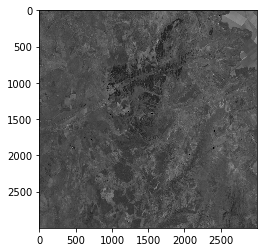

In [11]:
with rasterio.open(filename_nir) as dataset:
    print(dataset.profile)
    #img = dataset.read(1) ### open entire scene is heavy
    
    img = dataset.read(1, window=Window(0, 0, 3000, 3000)) ### Window(col_off, row_off, width, height)
    
    plt.imshow(img, cmap='gray')
    plt.show()

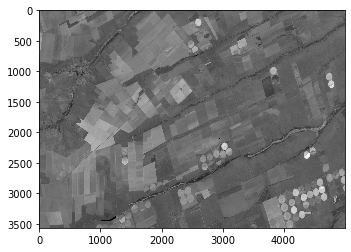

In [12]:
### CREATING BBOX ###
w = -45.90
n = -12.6
e = -45.40
s = -12.90

with rasterio.open(filename_nir) as dataset:
    img = dataset.read(1, window = longlat2window((w,e), (s,n), dataset)) ### Window(col_off, row_off, width, height)

    plt.imshow(img, cmap='gray')
    plt.show()

In [13]:
### Open several bands

In [14]:
print( bands )

dict_keys(['coastal', 'blue', 'green', 'red', 'redge1', 'redge2', 'redge3', 'nir', 'bnir', 'swir1', 'swir2', 'ndvi', 'evi'])


In [15]:
### select a few bands
my_bands = ('blue', 'green', 'red', 'nir')
my_bands

('blue', 'green', 'red', 'nir')

In [17]:
cube = my_cube['2018-09-01/2019-08-01']['tiles']['089098']['bands']
for band in my_bands:
    print( band )
    #load bands to xarray
    links = cube[band]
    print(links)

blue
['http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-09-01-2018-09-30/S10m_089098_2018-09-01_blue_STACK.tif', 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-10-01-2018-10-31/S10m_089098_2018-10-01_blue_STACK.tif', 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-11-01-2018-11-30/S10m_089098_2018-11-01_blue_STACK.tif', 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-12-01-2018-12-31/S10m_089098_2018-12-01_blue_STACK.tif', 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-01-01-2019-01-31/S10m_089098_2019-01-01_blue_STACK.tif', 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-02-01-2019-02-28/S10m_089098_2019-02-01_blue_STACK.tif', 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-03-01-2019-03-31/S10m_089098_2019-03-01_blue_STACK.tif', 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-04-01-2019-04-30/S10m_089098_2019-0